## План занятия
* Оптимизаторы
* Функции активации
* Нормализация
* Подбор гиперпараметров
* Системы логирования



In [2]:
import torch
from torch import nn

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets


## Оптимизаторы


Что такое оптимизатор? Вспомним, что у нас есть loss функция, и чем она меньше, тем лучше работает наша модель. То есть нам надо минимизировать ее. Грубо говоря, оптимизатор, это такой алгоритм, который берет на себя всю работу по изменению параметров модели, чтобы минимизировать loss.

Существует множество алгоритмов оптимизации. В нашем уроке нет особого смысла рассматривать их все. Список реализованных в PyTorch оптимизаторов можно посмотреть [здесь](https://pytorch.org/docs/stable/optim.html).
В интернете существует множество описаний того, как работают оптимизаторы.

Могу смело рекомендовать цикл видео на канале [3blue1brown](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) про нейронные сети и в частности про [градиентный спуск](https://youtu.be/IHZwWFHWa-w).

Еще можно почитать статьи на хабре, например, [эту](https://habr.com/ru/company/prequel/blog/568496/).

А вот [эту](https://habr.com/ru/post/318970/) очень-очень рекомендую!

Очень полезно будет почитать также записи к лекции курса [cs231n](https://cs231n.github.io/neural-networks-3/).

Давайте рассмотрим несколько самых популярных оптимизаторов:

* [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)
* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)



### SGD (Stochastic Gradient Descent)

Сам по себе стохастический градиентный спуск является очень простым алгоритмом.
$$x_{t+1} = x_{t} - \alpha \nabla f(x_{t})$$

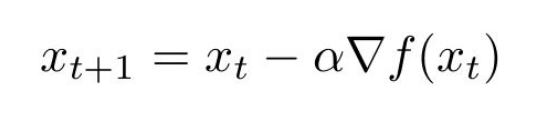

Мы можем записать это в коде следующим образом:

```python
while True:
    dx = compute_grad(x)
    x = x - lr * dx

```

Давайте посмотрим, как это выглядит в pytorch. Давайте возьмем какую-нибудь функцию, выберем начальное положение и попробуем погулять по этому рельефу при помощи градиентного спуска.

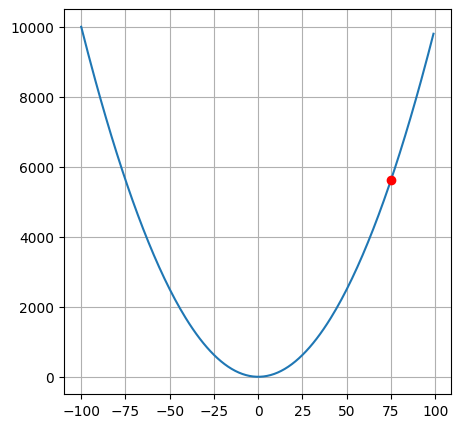

In [3]:
# define parabola
def f(x):
    return x ** 2

# generate x and f(x)
x = np.arange(-100, 100, 1)
y = f(x)

# define start position
x_pos = 75
y_pos = f(x_pos)

# plot results
plt.figure(figsize=(5, 5))
plt.plot(x,y)
plt.grid()
plt.plot(x_pos, y_pos, 'ro')

plt.show()

Выберем начальное положение и посмотрим, куда нам надо двигаться:

In [4]:
def df(x):
    return 2 * x

dx = df(x_pos)
print(dx)

150


Для того, чтобы нам сделать шаг оптимизации, нам необходимо пойти в сторону, противоположную направлению производной (градиенту в многомерном случае). При этом нам надо умножить его на `learning rate`.

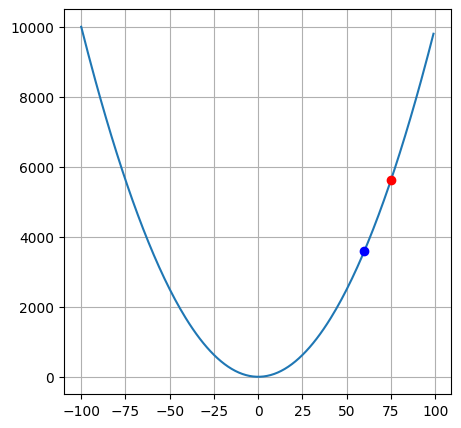

In [5]:
# define learning rate
learning_rate = 0.1

# calculate new x  position with help of gradient decent
new_x_pos = x_pos - learning_rate * dx

# calculate new y position just for draw
new_y_pos = f(new_x_pos)

# plot results
plt.figure(figsize=(5, 5))
plt.plot(x,y)
plt.plot(x_pos, y_pos, 'ro')
plt.plot(new_x_pos, new_y_pos, 'bo')
plt.grid()
plt.show()

Мы только что рассмотрели, как мы можем сделать один шаг градиентного спуска для параболы. Но это пока не дает представления о том, как же на самом деле работает алгоритм SGD. Зная вашу любовь к слайдерам, я поднотовил фрагмент кода ниже, где мы можем немного поиграться
с различными параметрами. Пока что мы можем оперировать только с `learning rate`.
<br>

Кстати, в PyTorch оптимизаторы находятся в модуле [torch.optim](https://pytorch.org/docs/stable/optim.html). Документацию по SGD можно почитать [здесь](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html).

In [6]:
LEARNING_RATE = 1.1
num_of_steps = 200

def f(x):
    return x ** 2

x = np.arange(-100,100,1)

# define torch tensor for optimization
weights = torch.tensor(75, dtype=torch.float32, requires_grad=True)

# define optimizer
optimizer = torch.optim.SGD([weights], lr=LEARNING_RATE, momentum=0)

# calculate y for drawing
y = f(torch.from_numpy(x)).numpy()

# list of historical positions of x and y
x_pos = [weights.item()]
y_pos = [f(weights).item()]

# Calculate positions for given number of steps
for i in range(num_of_steps):
    # Important step to remove old grads
    optimizer.zero_grad()

    # Calculate "loss" function
    res = f(weights)

    # backward step
    res.backward()

    # update weights
    optimizer.step()

    # append new position to lists for drawing
    x_pos.append(weights.item())
    y_pos.append(f(weights).item())


# function for drawing results
def update_plot(step):
    # init figure
    plt.figure(figsize=(5, 5))
    # plot graph
    plt.plot(x,y)
    # plot points
    plt.plot(x_pos[:step], y_pos[:step], 'ro')
    # plot trace
    plt.plot(x_pos[:step+1], y_pos[:step+1])
    # plot current position
    plt.plot(x_pos[step], y_pos[step], 'bo')
    plt.grid()
    plt.show()


step = widgets.IntSlider(
    min=0, max=num_of_steps, value=0, description='step:'
    )

widgets.interactive(update_plot, step=step)

interactive(children=(IntSlider(value=0, description='step:', max=200), Output()), _dom_classes=('widget-inter…

Давайте определим функцию поинтереснее, чем парабола:

In [7]:
LEARNING_RATE = 10.5
num_of_steps = 200

def f(x):
    return x * torch.cos(0.1*x)

x = np.arange(-100,100,1)

# define torch tensor for optimization
weights = torch.tensor(55, dtype=torch.float32, requires_grad=True)
# define optimizer
optimizer = torch.optim.SGD([weights], lr=LEARNING_RATE, momentum=0)

# calculate y for drawing
y = f(torch.from_numpy(x)).numpy()

# list of historical positions of x and y
x_pos = [weights.item()]
y_pos = [f(weights).item()]

# Calculate positions for given number of steps
for i in range(num_of_steps):
    # Important step to remove old grads
    optimizer.zero_grad()
    # Calculate "loss" function
    res = f(weights)
    # backward step
    res.backward()
    # update weights
    optimizer.step()

    # append new position to lists for drawing
    x_pos.append(weights.item())
    y_pos.append(f(weights).item())


# function for drawing results
def update_plot(step):
    # init figure
    plt.figure(figsize=(5, 5))
    # plot graph
    plt.plot(x,y)
    # plot points
    plt.plot(x_pos[:step], y_pos[:step], 'ro')
    # plot trace
    plt.plot(x_pos[:step+1], y_pos[:step+1])
    # plot current position
    plt.plot(x_pos[step], y_pos[step], 'bo')
    plt.grid()
    plt.show()

step = widgets.IntSlider(
    min=0, max=num_of_steps, value=0, description='step:'
    )

widgets.interactive(update_plot, step=step)

interactive(children=(IntSlider(value=0, description='step:', max=200), Output()), _dom_classes=('widget-inter…

Какие проблемы есть у SGD? <br>
Он не смотрит вообще на то, что было до текущего момента. Куда укажет градиент, туда и прыгнем. Было бы здорово, если бы мы могли запоминать нашу траекторию. Получчается, что если мы довольно долго двигались в одном направлении, то логичнее всего, что мы должны продолжить двигаться в этом же направлении, даже если текущий градиент укажет в другую сторону или окажется нулевым.

Если раньше у нас была следующая формула:

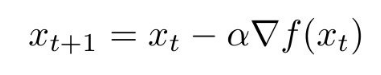

То добавление моментов выглядит так:

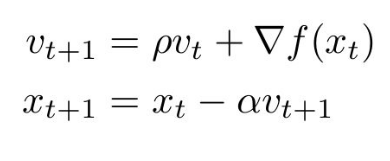

По-сути, мы добавляем скорость как скользящее среднее по предыдущим градиентам. Также мы добавляем небольшое трение $\rho$. Обычно параметро $\rho$ находится в пределах от 0.9 до 0.99. Графически мы можем вычислить это следующим образом:

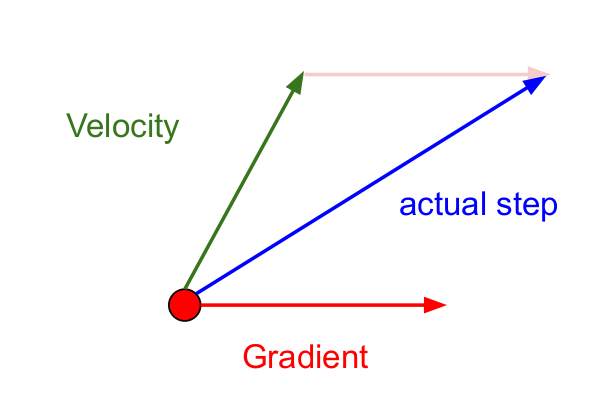

 Давайте поиграемся с ним на нашем интерактивном графике:

In [8]:
LEARNING_RATE = .1
num_of_steps = 200

momentum = 0.99

def f(x):
    return x * torch.cos(0.1*x)

x = np.arange(-100,100,1)


# define torch tensor for optimization
weights = torch.tensor(55, dtype=torch.float32, requires_grad=True)
# define optimizer
optimizer = torch.optim.SGD([weights], lr=LEARNING_RATE, momentum=momentum)


# calculate y for drawing
y = f(torch.from_numpy(x)).numpy()


# list of historical positions of x and y
x_pos = [weights.item()]
y_pos = [f(weights).item()]

# Calculate positions for given number of steps
for i in range(num_of_steps):
    # Important step to remove old grads
    optimizer.zero_grad()
    # Calculate "loss" function
    res = f(weights)
    # backward step
    res.backward()
    # update weights
    optimizer.step()

    # append new position to lists for drawing
    x_pos.append(weights.item())
    y_pos.append(f(weights).item())


# function for drawing results
def update_plot(step):
    # init figure
    plt.figure(figsize=(5, 5))
    # plot graph
    plt.plot(x,y)
    # plot points
    plt.plot(x_pos[:step], y_pos[:step], 'ro')
    # plot trace
    plt.plot(x_pos[:step+1], y_pos[:step+1])
    # plot current position
    plt.plot(x_pos[step], y_pos[step], 'bo')
    plt.grid()
    plt.show()


step = widgets.IntSlider(
    min=0, max=num_of_steps, value=0, description='step:'
    )

widgets.interactive(update_plot, step=step)

interactive(children=(IntSlider(value=0, description='step:', max=200), Output()), _dom_classes=('widget-inter…

На самом деле, моменты можно вычислять по-разному. Существует очень популярный момент Нестерова или (ускоренный градиент Нестерова). его смысл заключается в том, что мы вычисляем градиент не в текущей точке, а в точке, куда указывает вектор скорости. Результирующим шагом будет все также сумма вектора скорости и вектора градиента.

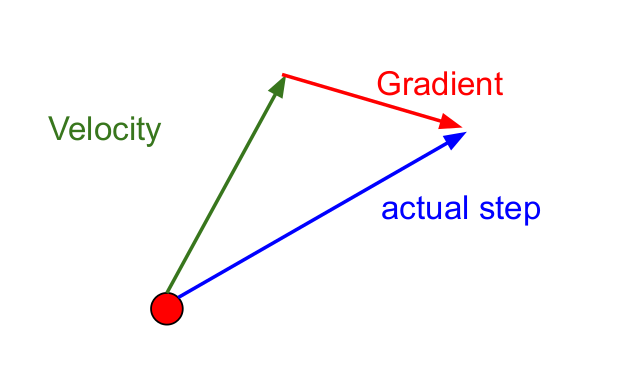

Такое изменение позволяет быстрее «катиться», если в стороне, куда мы направляемся, производная увеличивается, и медленнее, если наоборот.

In [14]:
LEARNING_RATE = 0.05

num_of_steps = 200

momentum = 1.2

def f(x):
    return x * torch.cos(0.1*x)

x = np.arange(-100,100,1)

# define torch tensor for optimization
weights = torch.tensor(55, dtype=torch.float32, requires_grad=True)
# define optimizer
optimizer = torch.optim.SGD(
    [weights], lr=LEARNING_RATE, momentum=momentum, nesterov=True
    )

# calculate y for drawing
y = f(torch.from_numpy(x)).numpy()

# list of historical positions of x and y
x_pos = [weights.item()]
y_pos = [f(weights).item()]

# Calculate positions for given number of steps
for i in range(num_of_steps):
    # Important step to remove old grads
    optimizer.zero_grad()
    # Calculate "loss" function
    res = f(weights)
    # backward step
    res.backward()
    # update weights
    optimizer.step()

    # append new position to lists for drawing
    x_pos.append(weights.item())
    y_pos.append(f(weights).item())

# function for drawing results
def update_plot(step):
    # init figure
    plt.figure(figsize=(5, 5))
    # plot graph
    plt.plot(x,y)
    # plot points
    plt.plot(x_pos[:step], y_pos[:step], 'o', color='red')
    # plot trace
    plt.plot(x_pos[:step+1], y_pos[:step+1])
    # plot current position
    plt.plot(x_pos[step], y_pos[step], 'o', color='blue')
    plt.grid()
    plt.show()

step = widgets.IntSlider(
    min=0, max=num_of_steps, value=0, description='step:'
    )

widgets.interactive(update_plot, step=step)

interactive(children=(IntSlider(value=0, description='step:', max=200), Output()), _dom_classes=('widget-inter…

### Adagrad

Мы поняли, что накапливать момент/импульсы здорово. Но существуют более замысловатые подходы к обновлению весов.
Допустим, есть признаки, которые встречаются достаточно редко, но при этом могут оказаться довольно информативными.

Идея Adagrad в том, чтобы использовать что-нибудь, что бы уменьшало обновления для элементов, которые мы и так сильно обновляем.


```python
eps = 1e-7
grad_squared = 0
while True:
    dx = compute_grad(x)
    grad_squared += dx ** 2
    x = x - lr * dx / sqrt(grad_squared + eps)

```

Достоинство Adagrad в отсутствии необходимости точно подбирать learning rate. Достаточно выставить его в меру большым, но не громадным, чтобы алгроритм не расходился. По сути мы получаем learning rate decay.

Недостаток алгоритма в том, что grad_squared может увеличиваться скольк угодно много и может застопорить оптимизацию.

### RMSProp
Мы хотим избавиться от недостатка алгоритма Adagrad. Будем вычислять не квадраты градиентов по всей истории обучания, а брать усреднённый по истории квадрат градиента.

```python
eps = 1e-7
grad_squared = 0
while True:
    dx = compute_grad(x)
    grad_squared += decay_rate * grad_squared + (1 - decay_rate) * dx ** 2
    x = x - lr * dx / sqrt(grad_squared + eps)

```

### Adam

Adam - adaptive moment estimation. По сути алгоритм является сочетанием идеи об использовании моментов/импульсов и идею более слабого обновления весов для типичных признаков.

```python
first_moment  = 0
second_moment = 0
while True:
    dx = compute_grad(x)
    first_moment = beta_1 * first_moment + (1 - beta_1) * dx
    second_moment = beta_2 * second_moment + (1 - beta_2) * dx * dx

    x = x - lr * first_moment / sqrt(second_moment + eps)
```

In [15]:
LEARNING_RATE = 1.5

num_of_steps = 200

momentum = 1.21

def f(x):
    return x * torch.cos(0.1*x)

x = np.arange(-100,100,1)


# define torch tensor for optimization
weights = torch.tensor(55, dtype=torch.float32, requires_grad=True)
# define optimizer
optimizer = torch.optim.Adam(
    [weights], lr=LEARNING_RATE
    )

# calculate y for drawing
y = f(torch.from_numpy(x)).numpy()

# list of historical positions of x and y
x_pos = [weights.item()]
y_pos = [f(weights).item()]

# Calculate positions for given number of steps
for i in range(num_of_steps):
    # Important step to remove old grads
    optimizer.zero_grad()
    # Calculate "loss" function
    res = f(weights)
    # backward step
    res.backward()
    # update weights
    optimizer.step()

    # append new position to lists for drawing
    x_pos.append(weights.item())
    y_pos.append(f(weights).item())


# function for drawing results
def update_plot(step):
    # init figure
    plt.figure(figsize=(5, 5))
    # plot graph
    plt.plot(x,y)
    # plot points
    plt.plot(x_pos[:step], y_pos[:step], 'o', color='red')
    # plot trace
    plt.plot(x_pos[:step+1], y_pos[:step+1])
    # plot current position
    plt.plot(x_pos[step], y_pos[step], 'o', color='blue')
    plt.grid()
    plt.show()


step = widgets.IntSlider(
    min=0, max=num_of_steps, value=0, description='step:'
    )


widgets.interactive(update_plot, step=step)

interactive(children=(IntSlider(value=0, description='step:', max=200), Output()), _dom_classes=('widget-inter…

### Что делать с learning rate


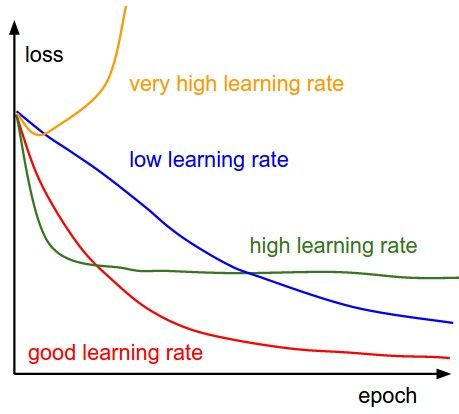

При приближении к некоторому минимуму loss функции нам бы хотелось опуститься как можно ниже. И иногда это сделать можно при помощи так назывваемых `shedulers`. <br>
Идея заключается в том, чтобы менять `learning rate` в соответствии с какой-то стратегией. Почитать про доступные варианты можно [здесь](https://pytorch.org/docs/stable/optim.html).




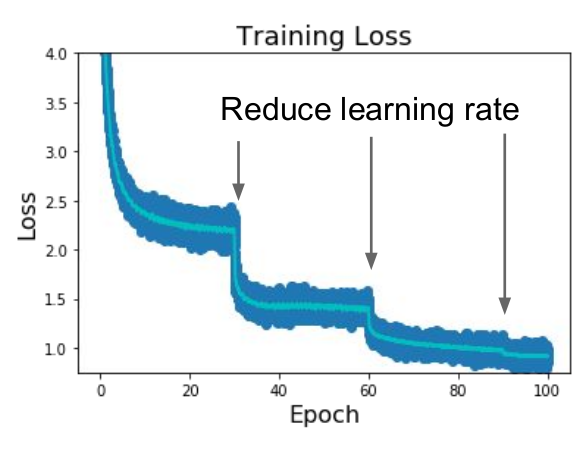

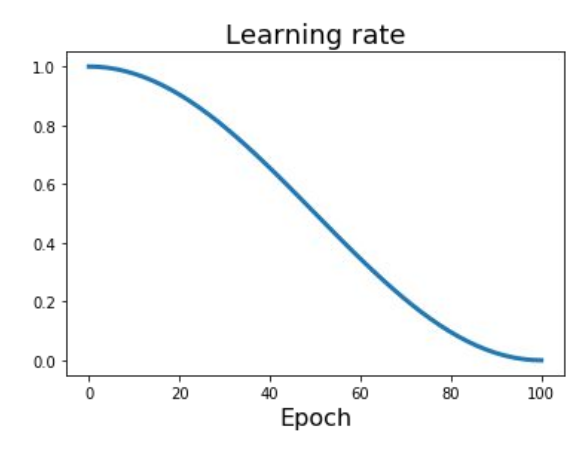

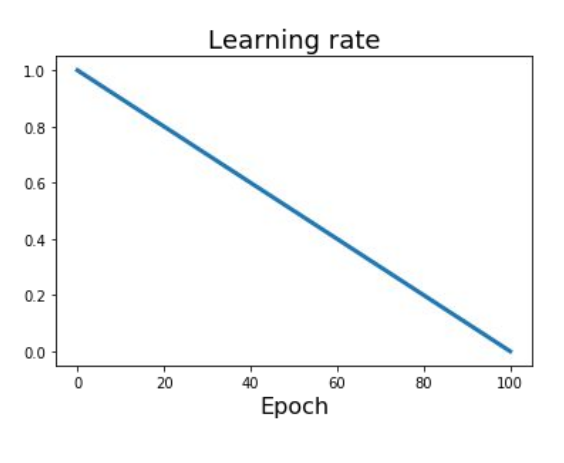

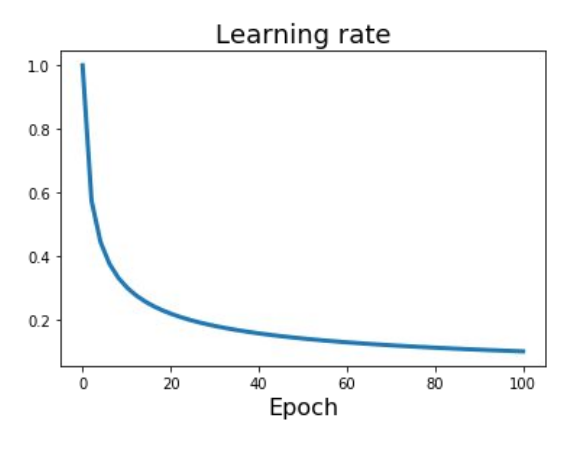

### Резюме

На практике хорошим выбором по дефолту будет Adam. Зачастую он неплохо работает даже без точного подбора learning rate.

Но до сих пор во многих репозиториях можно встретить обученные модели при помощи SGD + Momentum. При этом, конечно, потребуется поперебирать гиперпараметры и воспользоваться LR shedulers (рекомендуется начать с cosine sheduler).

## Функции активации



### Сигмоида

Сигмоида исторически была самой популярной функцией активации.
Преобразует все значения в диапазон от 0 до 1.

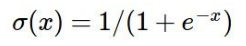

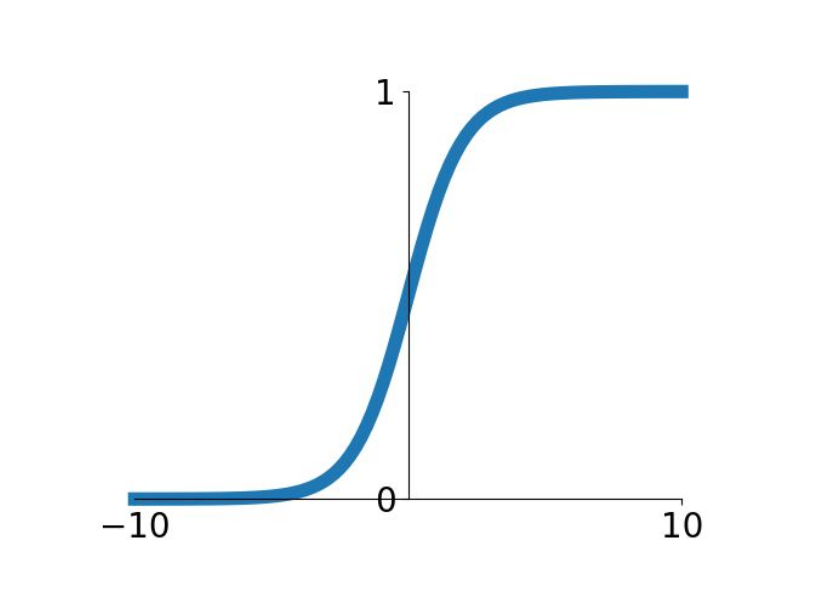

У сигмоиды существует три основных недостатка:
- Насыщенные нейроны будут "убивать" градиенты
- Сигмоида не центрированна
- Вычислительно затратная функция

### Гиперболический тангенс

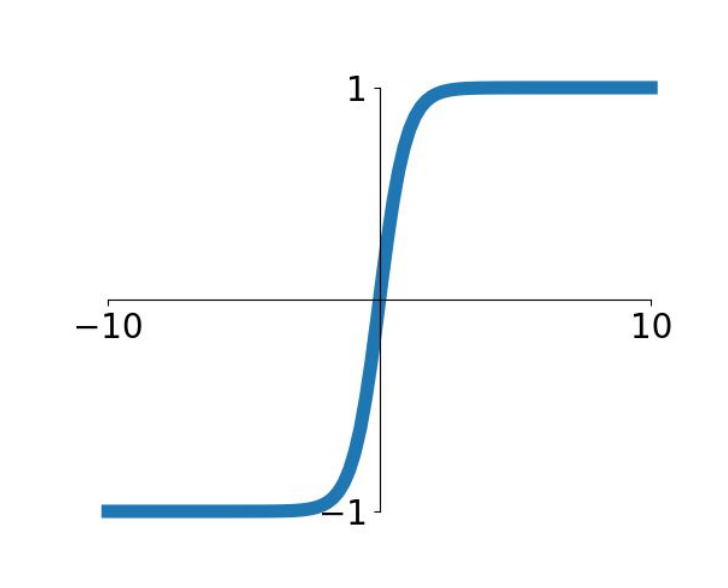

Имеет все те же недостатки, что и сигмоида, за исключением того, что гиперболический тангенс центрирован в нуле.

### ReLU

Это более простая функция, чем предыдущие две. По сути, это обрезанная линейная функция.

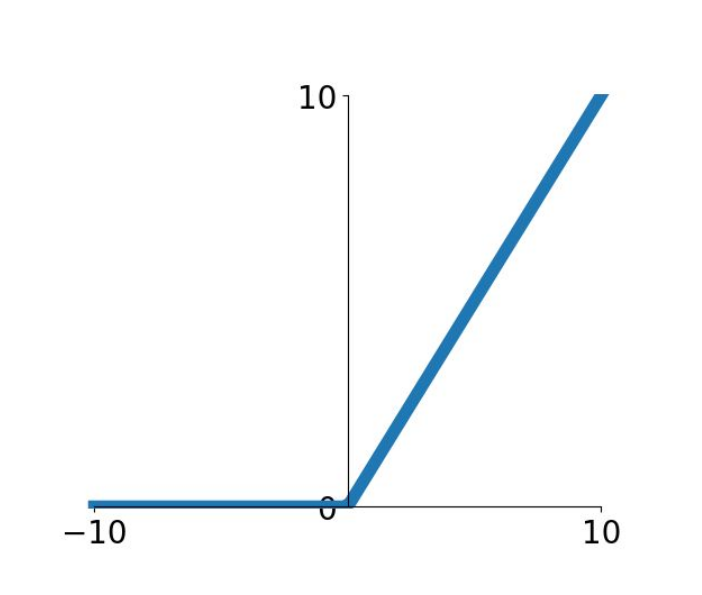

Она обладает следующими плюсами перед сигмоидой и гиперболическим тангенсом:

- Не убивает градиенты (в положительной части)
- Очень проста при вычислениях
- Зачастую позволяет моделе сходиться к минимуму быстрее, чем сигмоида и гиперболический тангенс.

Но также обладает недостатками, основной из которых это так называемый dead ReLu problem. Нейроны с отрицательным выходом будут после ReLU выдавать 0, а это значит, что градиент не будет обратно распространяться, а значит, что веса не будут обновляться.



### Leaky ReLU
Данную проблему решает использование другой линейной функции вместо нуля в ReLU. Теперь у нас градиенты не будут "умирать".

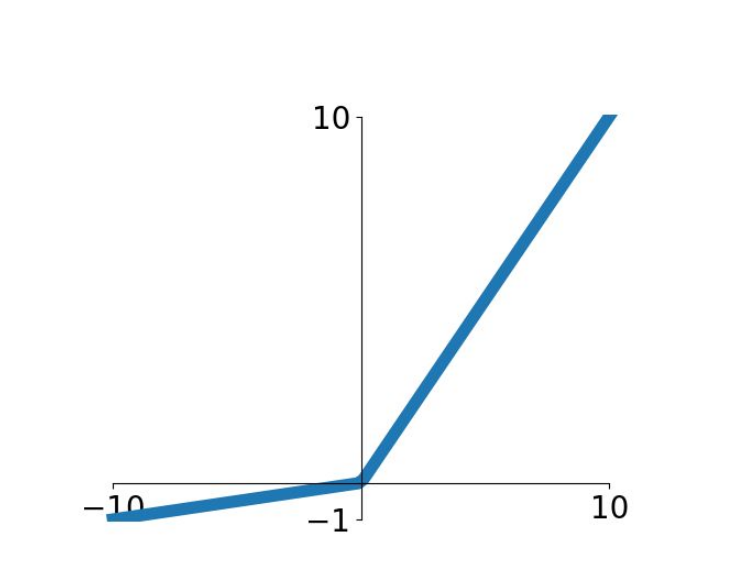

Существуют множество различных функций активации. Многие из них являются некоторым улучшением ReLU. Доступные опции в PyTorch можно посмотреть [здесь](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).

Общие рекомендации дать сложно, но обычно можно сказать следующее:

- Стоит начать свои эксперименты с ReLU
- Также можно поэкспериментировать с улучшенными версиями ReLU
- По возможности избегать сигмоиду и гиперболический тангенс


## Нормализация данных

Обычной практикой перед обучением моделей является нормализация данных. Самым простым вариантом является центрирование и масштабирование данных:

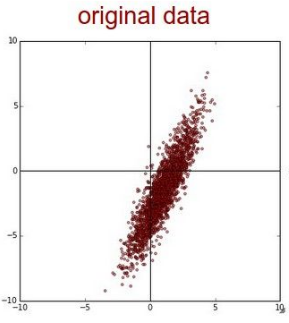

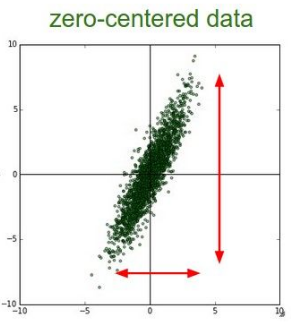

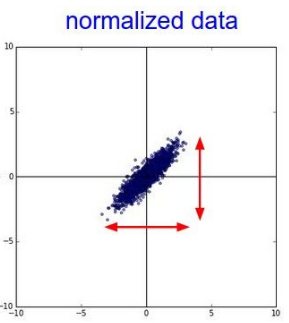

До нормализации данных мы можем иметь следующую картину:

В этом случае лосс будет очень чувствительным к изменения параметров весов, будет сложнее обучать модель.

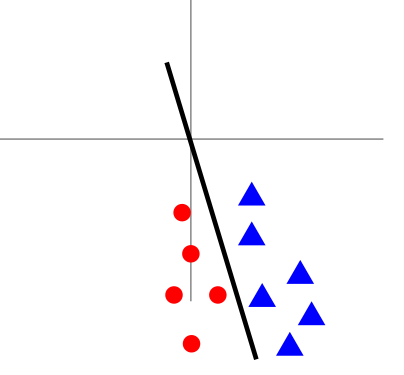

Здесь мы уже не будем так чувствительны к небольшим изменениям весов, легче обучать.

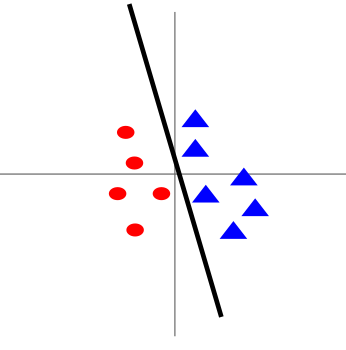

### Слои нормализации

Суть данного метода заключается в том, что некоторым слоям нейронной сети на вход подаются данные, предварительно обработанные и имеющие нулевое математическое ожидание и единичную дисперсию.

Использование нормализации по мини-батчам обладает полезными свойствами:

* достигается более быстрая сходимость моделей, несмотря на выполнение дополнительных вычислений;
* батч нормализация позволяет каждому слою сети обучаться более независимо от других слоев;
* становится возможным использование более высокого темпа обучения, так как пакетная нормализация гарантирует, что выходы узлов нейронной сети не будут иметь слишком больших или малых значений;
* пакетная нормализация в каком-то смысле также является механизмом регуляризации;
* модели становятся менее чувствительны к начальной инициализации весов.

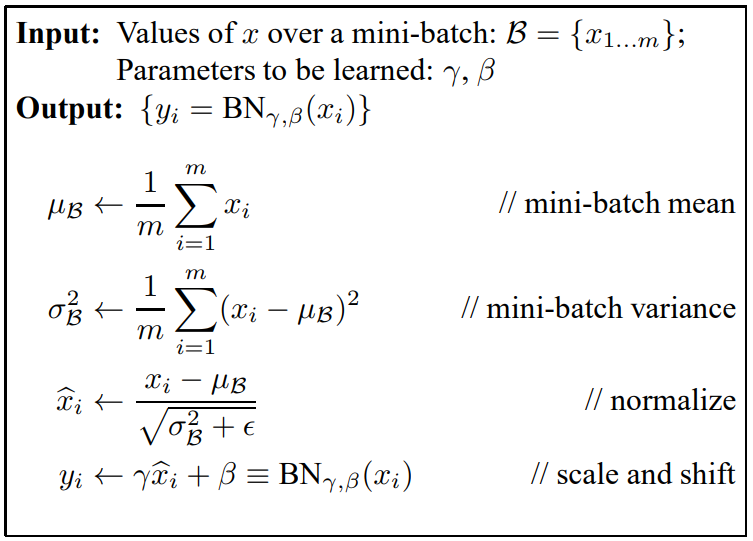

[source](https://arxiv.org/pdf/1502.03167.pdf)

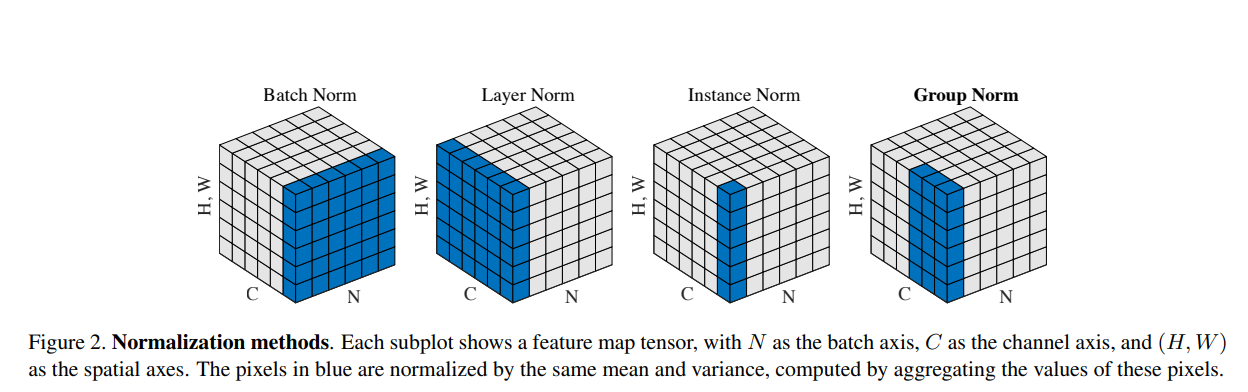
[Source](https://arxiv.org/pdf/1803.08494.pdf)

Обычно нормализация используется после выхода полносвязного слоя (или сверточного слоя) и перед функцией активации.


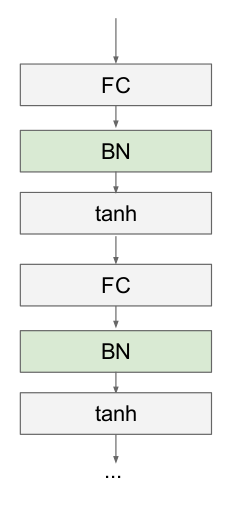

# Системы логирования

Наиболее популярные:
* [Weights&Biases](https://docs.wandb.ai/): [c чего начать](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/intro/Intro_to_Weights_%26_Biases.ipynb)
* [Tensorboard](https://www.tensorflow.org/tensorboard): [пример использования](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/get_started.ipynb), [как подружить с ноутбуками](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb)
* [MLFlow](https://mlflow.org/)

## Подбор гиперпараметров

В целом, алгоритм заключается примерно в следующем:

1: Check initial loss

2: Overfit a small sample

3: Find LR that makes loss go down

4: Coarse grid, train for ~1-5 epochs

5: Refine grid, train longer

6: Look at loss and accuracy curves

### Наблюдаем за loss и метриками:



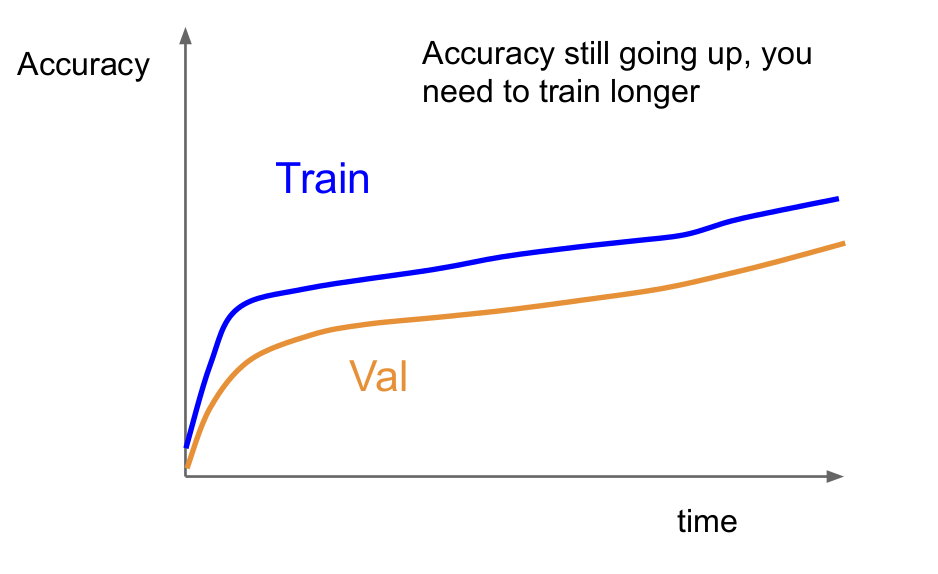

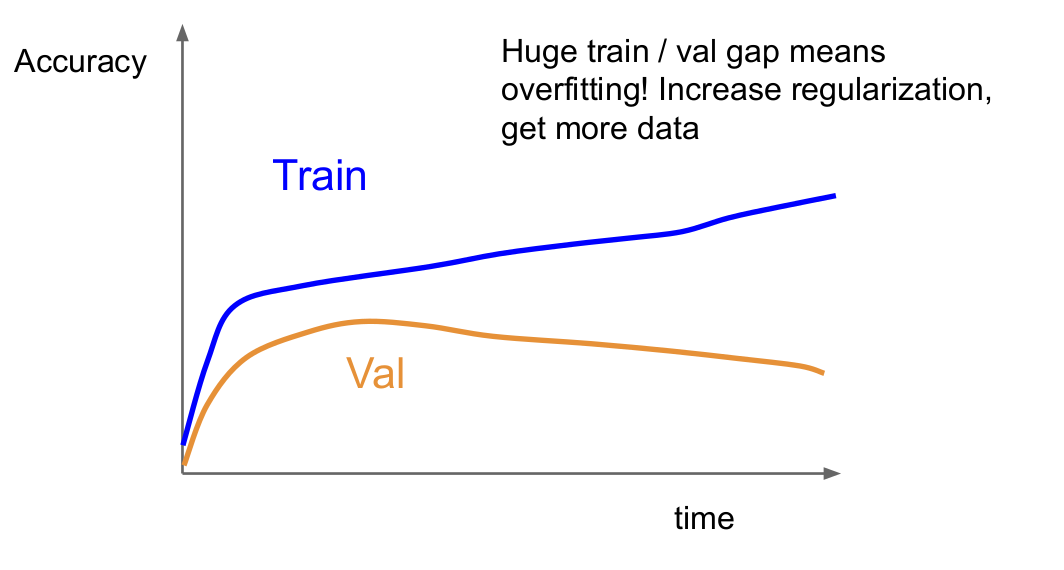

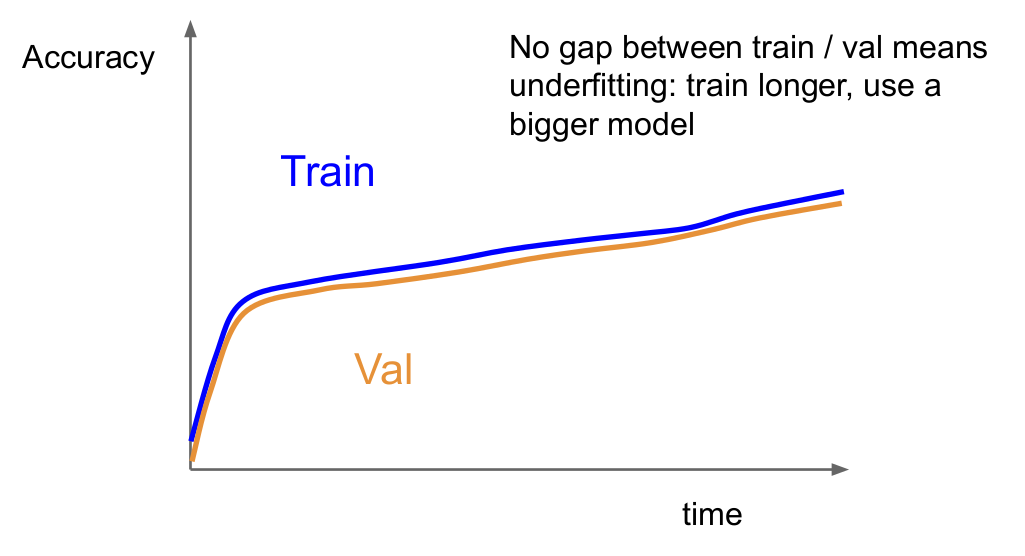

# Joy train

Здесь мы решим простую регрессионную задачу: научим модель переводить градусы Цельсия в Фаренгейты по формуле

`𝐹  = 1.8 ⋅ 𝐶 + 32`


При этом:

- построим линейную модель nn.Linear(1,1),

- обучим по MSE (mean squared error) оптимизатором Adam,

- визуализируем кривую потерь, проверим предсказание и считаем обученные веса (наклон и сдвиг).

In [16]:
# Импорт минимальных зависимостей и настройка воспроизводимости
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

Небольшая демо-визуализация (как в исходном ноутбуке)

Построим график функции

`5sin(x)+2x `

просто для разминки и проверки отрисовки.

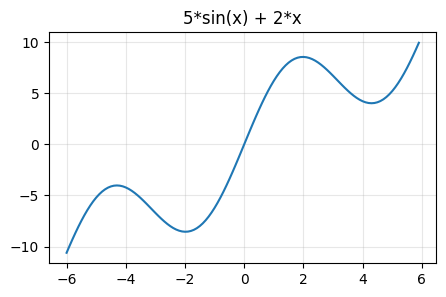

In [17]:
x = np.arange(-6, 6, 0.1)
y = 5*np.sin(x) + 2*x

plt.figure(figsize=(5,3))
plt.plot(x, y)
plt.title("5*sin(x) + 2*x")
plt.grid(True, alpha=0.3)
plt.show()


# Данные: пары (Цельсий → Фаренгейт)

Возьмём небольшой набор точек, как в исходном примере, и подготовим их для PyTorch:

- вход C и целевой F приведём к типу float32,

- добавим размерность признака (-1, 1) (один входной признак),

- перенесём тензоры на device.

In [18]:
# Исходные точки (как в исходном ноутбуке)
C_np = np.array([-40, -10,   0,  8, 15, 22, 38], dtype=np.float32)
F_np = np.array([-40,  14,  32, 46, 59, 72,100], dtype=np.float32)

# В тензоры PyTorch: столбцы (-1,1)
C = torch.from_numpy(C_np).view(-1, 1).to(device)  # (N,1)
F = torch.from_numpy(F_np).view(-1, 1).to(device)  # (N,1)

C, F


(tensor([[-40.],
         [-10.],
         [  0.],
         [  8.],
         [ 15.],
         [ 22.],
         [ 38.]], device='cuda:0'),
 tensor([[-40.],
         [ 14.],
         [ 32.],
         [ 46.],
         [ 59.],
         [ 72.],
         [100.]], device='cuda:0'))

# Модель: линейная регрессия

`F≈w⋅C+b`

Используем `nn.Linear(1,1)`, где:

weight соответствует коэффициенту

- w (наклон, ожидаем ~1.8),

- bias соответствует смещению b (ожидаем ~32).

In [21]:
model = nn.Linear(in_features=1, out_features=1).to(device)
print(model)

# Быстрый взгляд на начальные параметры
w0 = model.weight.detach().cpu().item()
b0 = model.bias.detach().cpu().item()
print(f"Начальные w={w0:.4f}, b={b0:.4f}")


Linear(in_features=1, out_features=1, bias=True)
Начальные w=-0.2191, b=0.2018


# Функция потерь и оптимизатор

- Loss: MSELoss (среднеквадратичная ошибка).

- Оптимизатор: Adam с повышенным lr=0.1, чтобы быстро сойтись на такой простой задаче.

Обучаем 500 эпох, логируем loss для графика.

In [22]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

loss_history = []
EPOCHS = 500

model.train()
for epoch in range(1, EPOCHS+1):
    # Прямой проход
    pred = model(C)          # (N,1)
    loss = criterion(pred, F)

    # Шаг оптимизации
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d}: loss={loss.item():.6f}")


Epoch   1: loss=3888.622559
Epoch  50: loss=729.220337
Epoch 100: loss=507.432037
Epoch 150: loss=348.089539
Epoch 200: loss=230.512970
Epoch 250: loss=147.155060
Epoch 300: loss=90.402504
Epoch 350: loss=53.358051
Epoch 400: loss=30.218172
Epoch 450: loss=16.407394
Epoch 500: loss=8.541014


# Кривая обучения (loss)

Посмотрим, как убывает MSE по эпохам.

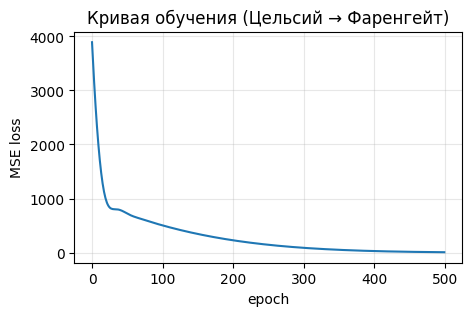

In [23]:
plt.figure(figsize=(5,3))
plt.plot(loss_history)
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("Кривая обучения (Цельсий → Фаренгейт)")
plt.grid(True, alpha=0.3)
plt.show()


Проверка модели: предсказание для 100°C

Ожидаем  `F=1.8⋅100+32=212.`

In [24]:
model.eval()
with torch.no_grad():
    F_100 = model(torch.tensor([[100.0]], device=device))
print("Предсказание для 100°C:", F_100.item())


Предсказание для 100°C: 211.32493591308594


Смотрим обученные параметры 𝑤 и b

Сравним их с «истинными» коэффициентами 1.8 и 32.

In [25]:
w = model.weight.detach().cpu().item()
b = model.bias.detach().cpu().item()
print(f"Обученные параметры: w={w:.6f}, b={b:.6f}")
print(f"Ожидание (теория):   w≈1.800000, b≈32.000000")

# Быстрая числовая проверка на обучающих точках
with torch.no_grad():
    pred_train = model(C).cpu().numpy().flatten()
print("Real F:      ", F_np)
print("Predicted F: ", np.round(pred_train, 3))


Обученные параметры: w=1.823236, b=29.001354
Ожидание (теория):   w≈1.800000, b≈32.000000
Real F:       [-40.  14.  32.  46.  59.  72. 100.]
Predicted F:  [-43.928  10.769  29.001  43.587  56.35   69.113  98.284]


Итоги

- Линейная модель на PyTorch выучила преобразование  `𝐶 → 𝐹`и нашла параметры, близкие к `𝑤=1.8` и `𝑏=32`


# [Свёрточная нейронная сеть](https://ru.wikipedia.org/wiki/%D0%A1%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D0%B0%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C) (CNN) — архитектура искусственных нейронных сетей, предложенная Яном Лекуном в 1998 году.

[Ссылка](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) на статью.

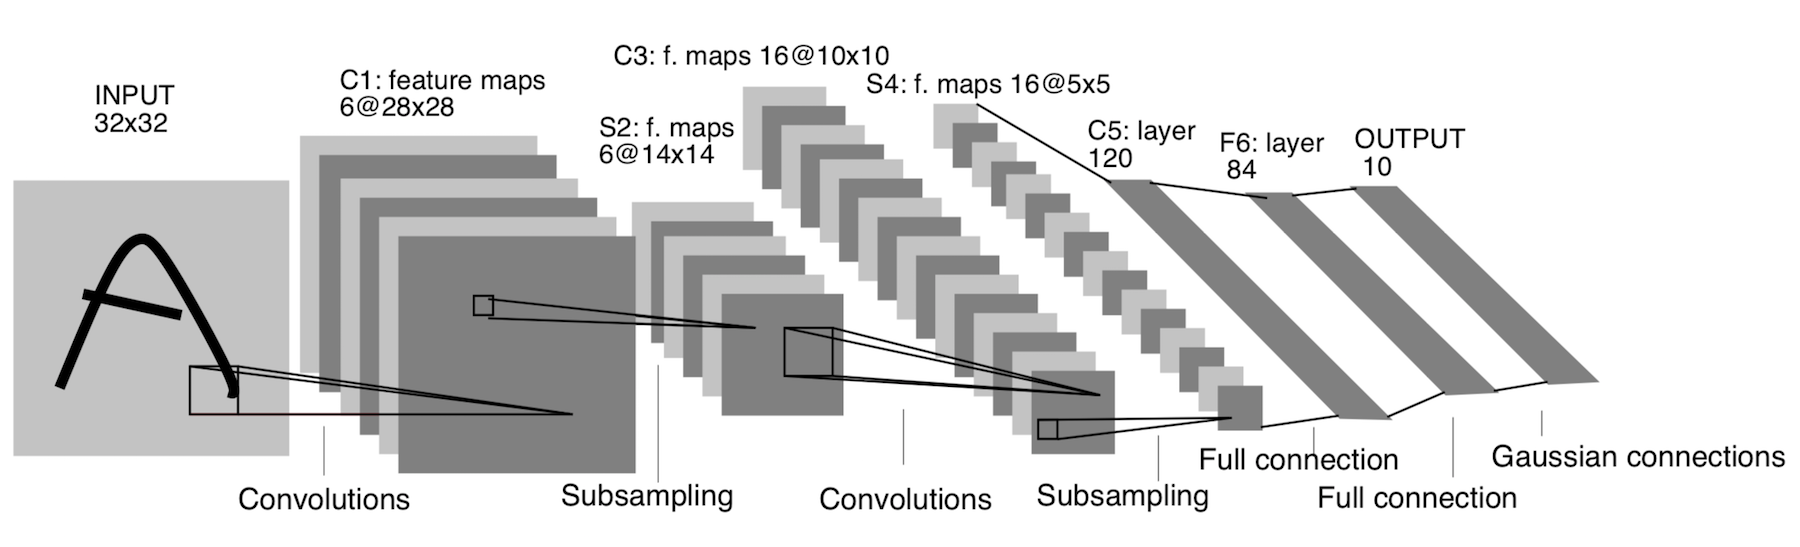

Данная архитектура была разработана для распознавания рукописных цифр. Она решала эту задачу лучше остальных алгоритмов. Но внимание к сверточным нейронным сетям было недостаточным до тех пор, пока в 2012 году не появилась сеть AlexNet, которая обошла все остальные подходы в конкурсе ImageNet.



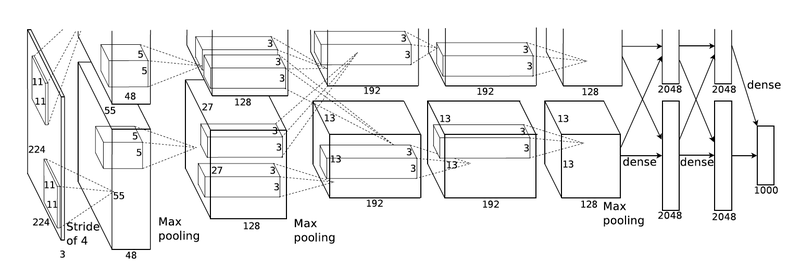

## Свертка

Свертка — операция над парой матриц A (размера nx×ny) и B (размера mx×my), результатом которой является матрица C=A∗B размера (nx−mx+1)×(ny−my+1). Каждый элемент результата вычисляется как скалярное произведение матрицы B и некоторой подматрицы A такого же размера (подматрица определяется положением элемента в результате).

![image](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif)

То есть мы задаем некую матрицу --  ядро, которое обычно является квадратной матрицей небольшого размера, состоящей из вещественных чисел (это и будут наши обучаемые веса).

Это ядро перемещается по матрице (которая является обрабатываемым изображением или результатом других сверток), совершая поэлементное умножение пересекшихся матриц.

Далее результаты умножения складываются между собой (на самом деле туда же добавляется некоторое смещение). В результате мы получаем одной число, которое записывается в результирующую матрицу в позицию, соответствующую положению ядра свертки на момент вычислений.

![image](https://media4.giphy.com/media/i4NjAwytgIRDW/giphy.gif?cid=ecf05e47ca4a484ptketvw6cd82z802f9inx0g0hoi62xiin&ep=v1_gifs_search&rid=giphy.gif&ct=g)










Давайте посмотрим на примере, почему нас так интересует операция свертки.

Если некоторая характеристика присутствует во фрагменте изображения под ядром свертки, операция свертки на выходе будет выдавать большое значение. Если же характеристика отсутствует, выходное значение будет маленьким.

Давайте приведем несколько игрушечных примеров для визуализации.

In [26]:
import cv2
import torch
import numpy as np
import torchvision
from torch import nn


from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt

In [28]:
# Датасеты и лоадеры
#DATA_DIR = "/mnt/d/datasets" # например путь к папке с данными на диске D
DATA_DIR = "/content"
# загрузим датасет MNIST
test_data = torchvision.datasets.MNIST(
    root= DATA_DIR,
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 532kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.71MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.70MB/s]


(28, 28)


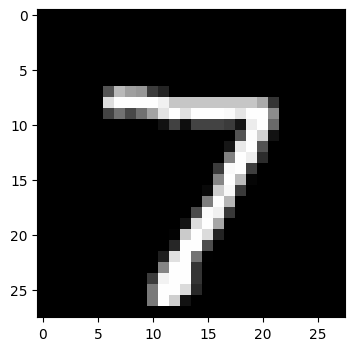

In [29]:
# Берем первое изображение из датасета
image, _ = test_data[0]
image = image.squeeze().numpy()
print(image.shape)
plt.figure(figsize=(4, 4))
plt.imshow(image, cmap='gray');

In [30]:
def apply_kernel(kernel, img, bias):
    # Нормализуем ядро (только для того, чтобы результат работы не превышал 1)
    kernel /= np.sum(kernel)
    conv_result = cv2.filter2D(img, -1, kernel)
    # Добавляем смещение
    conv_result += bias
    # Применяем  ReLU
    conv_result[conv_result < 0] = 0
    return conv_result

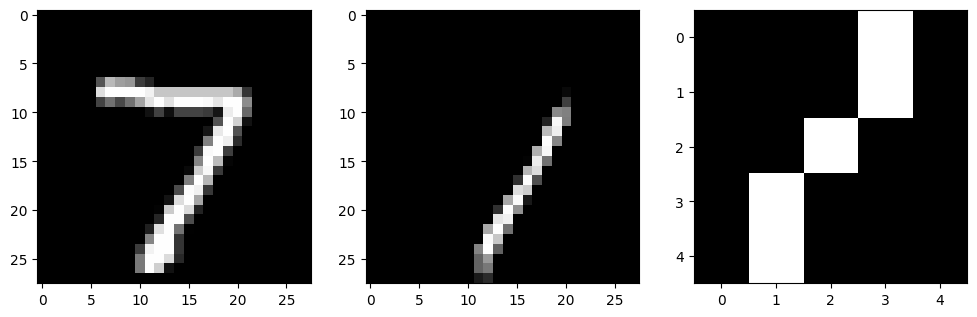

In [31]:
# Создадим ядро
kernel = np.array(
    [
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
    ],
    dtype=np.float32
)

# Отображаем результат
figure, plots = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
for img, subplot in zip([image, apply_kernel(kernel, image, -0.5), kernel], plots):
    subplot.imshow(img, cmap='gray')
plt.show()

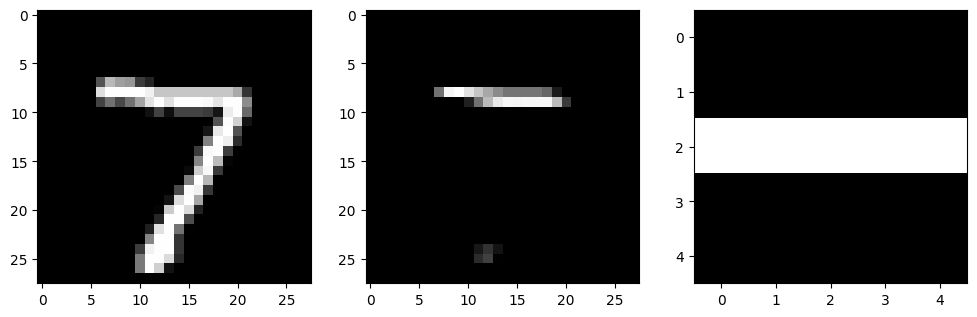

In [32]:
# Создадим ядро
kernel = np.array(
    [
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ],
    dtype=np.float32
)

# Отображаем результат
figure, plots = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
for img, subplot in zip([image, apply_kernel(kernel, image, -0.6), kernel], plots):
    subplot.imshow(img, cmap='gray')
plt.show()

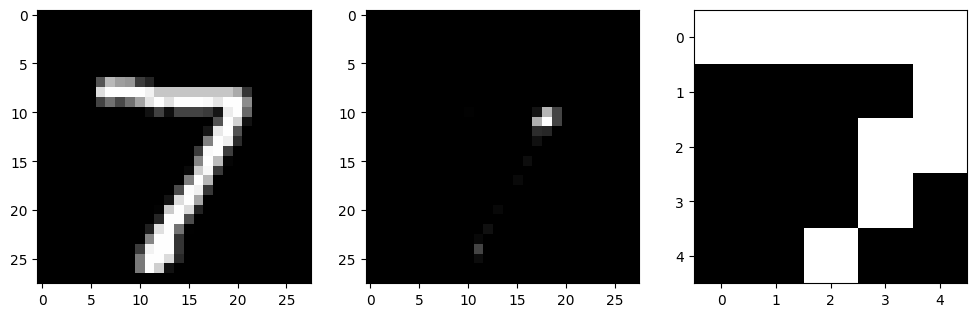

In [33]:
# Создадим ядро
kernel = np.array(
    [
        [1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 1],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
    ],
    dtype=np.float32
)

# Отображаем результат
figure, plots = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
for img, subplot in zip([image, apply_kernel(kernel, image, -0.6), kernel], plots):
    subplot.imshow(img, cmap='gray')
plt.show()

Давайте сделаем то же самое при помощи PyTorch. Для применения двумерной свертки нам нужен класс [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).

In [34]:
# Создаем сверточный слой
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, stride=1, padding=2)
# Выведем веса
print(conv.weight)
# Выведем смещение
print(conv.bias)

Parameter containing:
tensor([[[[-0.0974,  0.1175,  0.1763, -0.1467,  0.1738],
          [ 0.0374,  0.1478,  0.0271,  0.0964, -0.0282],
          [ 0.1542,  0.0296, -0.0934,  0.0510, -0.0921],
          [-0.0235, -0.0812,  0.1327, -0.1579, -0.0922],
          [-0.0565, -0.1203,  0.0189, -0.1975,  0.1806]]]], requires_grad=True)
Parameter containing:
tensor([-0.1699], requires_grad=True)


In [35]:
# Создадим ядро
kernel = np.array(
    [[[
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
    ]]],
    dtype=np.float32
)
# Нормализуем его (только для того, чтобы результат работы не превышал 1)
kernel /= np.sum(kernel)
# Обмновим веса
conv.weight.data = torch.tensor(kernel)

# Обновим смещение
conv.bias.data = torch.tensor([-0.5])

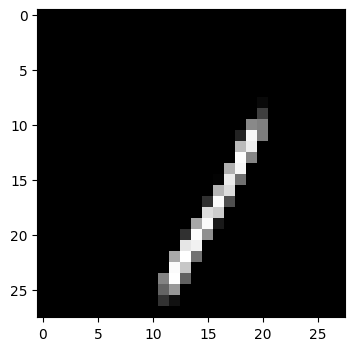

In [37]:
# Берем первый элемент из датасета
image, _ = test_data[0]

image = torch.unsqueeze(image, 0)

# Применим ReLU(Conv2d(image))
res = nn.ReLU()(conv(image))
res = res[0][0].detach().numpy()
# Отрисуем результат
plt.figure(figsize=(4, 4))
plt.imshow(res, cmap='gray');

### Padding

Посмотрим еще раз на эту картинку:


![image](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif)

Мы можем заметить, что после выполнения свертки размер выхода уменьшился.
Все дело в том, что крайние пиксели не попадают в центр ядра, что обусловлено принятыми правилами передвижения. Иногда нам нужно вернуть результат такого же размера, как и исходная матрица. Для этого используется Паддинг. По сути мы добавляем дополнительные пиксели по краям исходного изображение, чтобы после свертки мы получили на входе и выходе матрицы с одинаковыми размерами.

![image](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif)

Играясь с размером паддинга мы можем получить различные размеры выходной матрицы.

![image](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/full_padding_no_strides.gif)

Но, очевидно, нет особого смысла делать padding большего размера, чем ядро.

### Stride


Довольно часто мы хотим уменьшить размер выходной матрицы.
Один из способов достижения такого результата — использование пулингового  слоя, о котором мы поговорим ниже.

Другой способ — использование страйда. По-сути мы просто перемещаем наше ядро с заданным шагом. В результате выходная матрица уменьшается в размерах относительно входной.


![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides.gif)

### Сравнение с полносвязным слоем

Допустим у нас есть изображение с размером (4, 4) и ядро свертки (3, 3).
Как на нашей уже знакомой гифке:

![image](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif)

На выходе мы получаем изображение размером (2, 2). Для того, чтобы сделать такое же при помощи полносвязного слоя нам необходимо растянуть наше исходно изображение в вектор длины 16 и умножить на матрицу с весами:




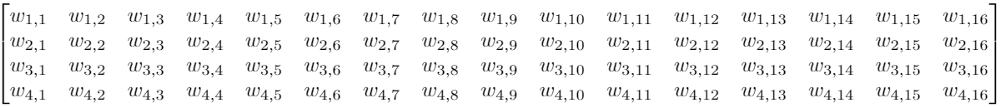

То, что делают свертки может показаться не совсем очевидным, но это по факту все тот же линейный оператор. Только его матрица будет иметь специфичный вид. Для нашего случая с ядром (3, 3) соответствующая матрица линейного оператора будет выглядеть следующим образом:

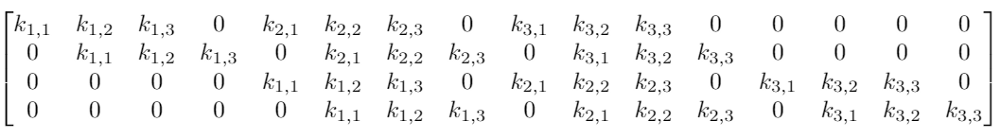

Обратите внимание на сходство данноых матриц. Хоть и размерности матриц идентичны, но в первом случае матрица является характеристикой множественных связей между одномерными слоями, во втором же случае — характеристикой работы ядра в двумерном пространстве.

Также мы можем обратить внимание на то, что в данной матрице всего лишь 9 параметров, вместо 64. Остальные нули.

### Многоканальная свертка

Quiz: сколько обучаемых параметров (или весов) в свертке, инициализированной следующим образом:

nn.Conv2d(5, 10, 3)

#### hint1
Свертка работает с размером канальности точно также как с пространственными размерами: свертка 3x3 на входе с n каналами будет иметь размер nx3x3

#### hint2
На выходе будет столько каналов сколько сверток мы зададим. Т.е. 10 сверток в данном случае.

#### hint3
Не забывайте, что по умолчанию свертка имеет свободный параметр. Каждая свертка будет иметь один bias, поэтому еще 10 параметров

In [ ]:
conv = nn.Conv2d(5, 10, 3)

In [ ]:
conv.weight.data.shape
conv.bias.data.shape

torch.Size([10])


Для входного изображения с размерами $ (С, W_1, H_1) $

Сверточный слой имеет 4 гиперпараметра:
- Количество фильтров $K$
- Размер ядра $F$
- Stride $S$
- Padding $P$


В результате будет получен выход с размерами $(K, W_2, H_2)$:

Где:
- $W_2 = (W_1 - F + 2P) / S + 1$
- $H_2 = (H_1 - F + 2P) / S + 1$

Количество обучаемых параметров: $F^2 * C * K + K$ смещений

## 1x1 Convolution

<img src="https://i.ibb.co/GCF4X3q/1x1-conv.png" height="400" width="500"/>

## 3D Convolution:

<img src="https://i.ibb.co/B4P4Q99/3D-conv.png" height="200" width="700"/>

#### Как сделать операцию которая бы увеличивала размер входного изображения при помощи сверток?

<img src="https://i.ibb.co/vVQ4nM6/upsampling-1.gif" height="300" width="300"/>

<img src="https://i.ibb.co/Zh57nxV/upsampling-2.gif" height="300" width="300"/>

Обычная свертка:

<img src="https://i.ibb.co/GHjy0P1/conv-1.png" height="500" width="700"/>

Транспонировананя свертка:

<img src="https://i.ibb.co/HdDNc5m/conv-t.png" height="450" width="700"/>

Одна из проблем апсемплинга - появление checkerboard артифактов.

<img src="https://i.ibb.co/h1Hyk6K/chbrd.png" width="800" height="400">

Детальней можно почитать [здесь](https://distill.pub/2016/deconv-checkerboard/).

# Pooling

Другим немаловажным строительным кирпичиком для сверточных нейронных сетей является операция пуллинга.

Идея заключается в следующем, после выхода сверточного слоя мы уменьшаем размер выходов, при этом стараясь сохранить наиболее важные активации.

Существует несколько популярных алгоритмов пуллинга. Посмотреть все алгоритмы, реализованные в пайторче можно [здесь](https://pytorch.org/docs/stable/nn.html#pooling-layers).


<img src="https://tse4.mm.bing.net/th/id/OIP.ZPwtYsg00tQo8H04OUu_MAHaDF?cb=12&rs=1&pid=ImgDetMain&o=7&rm=3" width="600" height="300">

torch.Size([1, 1, 28, 28])
(14, 14)


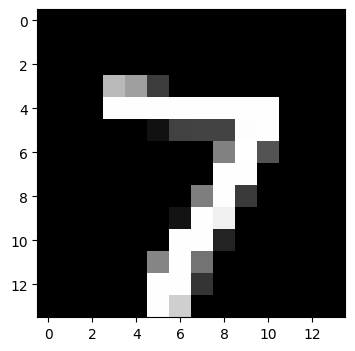

In [38]:
pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
image, _ = test_data[0]
# Добавим ему размерность, чтобы был формат N, C, H, W
image = torch.unsqueeze(image, 0)
print(image.shape)

# Применим MaxPool(image)
res = pool(image)
res = res[0][0].detach().numpy()
print(res.shape)

# Отрисуем результат
plt.figure(figsize=(4, 4))
plt.imshow(res, cmap='gray');


Для входного изображения с размерами $(С, W_1, H_1)$

Pooling слой имеет 2 гиперпараметра:
- Размер ядра $F$
- Stride $S$


В результате будет получен выход с размерами $(С, W_2, H_2)$:
- $W_2 = (W_1 - F ) / S + 1$
- $H_2 = (H_1 - F) / S + 1$


Количество обучаемых параметров: 0

#MNIST на PyTorch: обзор, данные, базовая CNN

- Разберёмся с объектом датасета (torchvision.datasets.MNIST) и тем, как брать элемент, батч, формы тензоров.

- Подготовим аугментации/нормализацию и DataLoader’ы для train/test.

- Обучим простую CNN на MNIST и оценим точность.

- Показать предсказания и ошибки (для наглядности).

In [39]:
# Импорты и базовые настройки
import os, random, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

#Работа с уже загруженным test_data


- как получить один элемент (image, label = test_data[i]),

- форму тензора и диапазон значений,

- как собрать батч через DataLoader

Размер test_data: 10000
Форма одного изображения: torch.Size([1, 28, 28]) | Метка: 7 | Тип и диапазон: torch.float32 (0.0, 1.0)


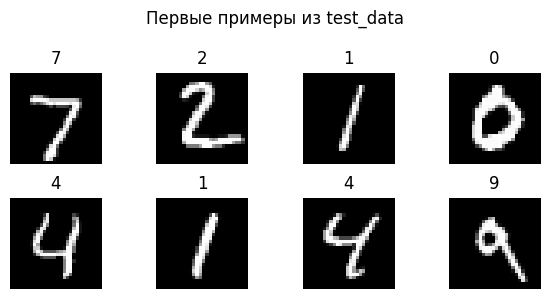

Форма батча: torch.Size([64, 1, 28, 28]) | Метки форма: torch.Size([64])


In [40]:
# Предполагается, что test_data уже создан ранее, как писал ты:
#DATA_DIR = "/mnt/d/datasets"
#test_data = torchvision.datasets.MNIST(root=DATA_DIR, train=False, download=True, transform=ToTensor())

len_test = len(test_data)
print("Размер test_data:", len_test)

# Достаём один элемент
x0, y0 = test_data[0]   # x0: тензор [1, 28, 28], y0: метка 0..9
print("Форма одного изображения:", x0.shape, "| Метка:", y0, "| Тип и диапазон:", x0.dtype, (float(x0.min()), float(x0.max())))

# Визуализируем несколько картинок из теста
plt.figure(figsize=(6,3))
for i in range(8):
    xi, yi = test_data[i]
    plt.subplot(2, 4, i+1)
    plt.imshow(xi.squeeze(0), cmap="gray")
    plt.title(int(yi))
    plt.axis("off")
plt.suptitle("Первые примеры из test_data")
plt.tight_layout()
plt.show()

# Соберём батч через DataLoader
test_loader_quick = DataLoader(test_data, batch_size=64, shuffle=False)
xb, yb = next(iter(test_loader_quick))
print("Форма батча:", xb.shape, "| Метки форма:", yb.shape)


# Нормализация и DataLoader’ы для обучения

Для обучения обычно добавляют нормализацию MNIST: mean=0.1307, std=0.3081.
Создадим:

- train_data (train=True) и test_data_norm (test с той же нормализацией),

- соответствующие DataLoader’ы.



In [41]:
# Нормализация под MNIST
mnist_mean, mnist_std = 0.1307, 0.3081
train_tfms = Compose([ToTensor(), Normalize((mnist_mean,),(mnist_std,))])
test_tfms  = Compose([ToTensor(), Normalize((mnist_mean,),(mnist_std,))])

# Загружаем train и test (нормализованные)
DATA_DIR = DATA_DIR  # используем ту же переменную пути
train_data = torchvision.datasets.MNIST(root=DATA_DIR, train=True,  download=True, transform=train_tfms)
test_data_norm = torchvision.datasets.MNIST(root=DATA_DIR, train=False, download=True, transform=test_tfms)

# Лоадеры (батчи компактные для быстрой тренировки)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_data_norm, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

len(train_data), len(test_data_norm)


(60000, 10000)

# Простая CNN для MNIST

Архитектура (минималистичная и быстрая):

- Conv(1→16, 3×3) → ReLU → MaxPool(2×2) → получаем 16×14×14

- Conv(16→32, 3×3) → ReLU → MaxPool(2×2) → 32×7×7

- Flatten → Linear(32⋅7⋅7 → 10).

In [42]:
class TinyMNISTCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # [B,16,28,28]
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # [B,32,28,28]
        self.pool  = nn.MaxPool2d(2)  # 28->14, 14->7
        self.fc    = nn.Linear(32*7*7, num_classes)

    def forward(self, x):
        # Блок 1: Conv-ReLU-Pool
        x = F.relu(self.conv1(x))  # [B,16,28,28]
        x = self.pool(x)           # [B,16,14,14]
        # Блок 2: Conv-ReLU-Pool
        x = F.relu(self.conv2(x))  # [B,32,14,14]
        x = self.pool(x)           # [B,32, 7,  7]
        # Классификатор
        x = torch.flatten(x, 1)    # [B,32*7*7]
        logits = self.fc(x)        # [B,10]
        return logits

model = TinyMNISTCNN().to(device)
print(model)


TinyMNISTCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


# Функция потерь, оптимизатор и цикл обучения

- Loss: CrossEntropyLoss.

- Optimizer: Adam (быстрая сходимость на MNIST).

- Логируем loss/accuracy на train и test по эпохам.

- Держим 3–5 эпох, чтобы было быстро. На MNIST такая CNN обычно даёт >98% точности уже за пару эпох.

In [43]:
from sklearn.metrics import accuracy_score

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def run_epoch(loader, train=True):
    if train: model.train()
    else:     model.eval()
    losses, y_true, y_pred = [], [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        # Логируем
        losses.append(loss.item())
        y_true.append(yb.detach().cpu())
        y_pred.append(logits.argmax(1).detach().cpu())
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    return np.mean(losses), accuracy_score(y_true, y_pred)

EPOCHS = 5
history = []
for ep in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    te_loss, te_acc = run_epoch(test_loader,  train=False)
    dt = time.time()-t0
    history.append((ep, tr_loss, tr_acc, te_loss, te_acc))
    print(f"Epoch {ep:02d} | train: loss={tr_loss:.4f}, acc={tr_acc:.3f} | "
          f"test: loss={te_loss:.4f}, acc={te_acc:.3f} | {dt:.1f}s")


Epoch 01 | train: loss=0.2426, acc=0.931 | test: loss=0.0798, acc=0.974 | 16.9s
Epoch 02 | train: loss=0.0691, acc=0.979 | test: loss=0.0623, acc=0.980 | 13.9s
Epoch 03 | train: loss=0.0509, acc=0.984 | test: loss=0.0426, acc=0.985 | 14.1s
Epoch 04 | train: loss=0.0411, acc=0.987 | test: loss=0.0380, acc=0.987 | 13.5s
Epoch 05 | train: loss=0.0356, acc=0.989 | test: loss=0.0328, acc=0.989 | 13.7s


# визуализация предсказаний

Покажем 16 картинок из теста с предсказанным классом и (если неверно) пометим ошибку.

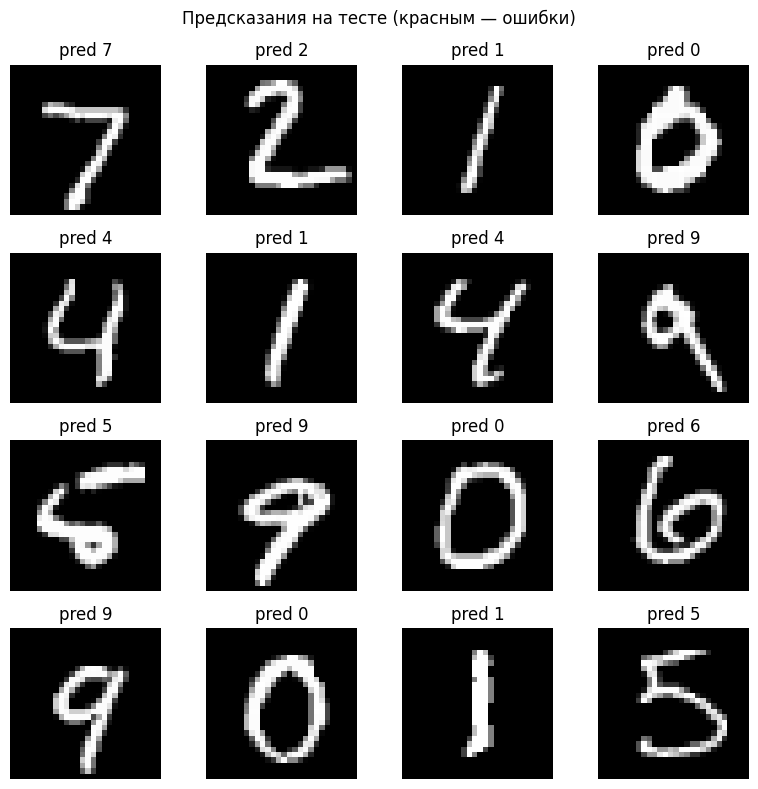

In [44]:
# Берём небольшой батч из теста
xb, yb = next(iter(test_loader))
xb, yb = xb.to(device), yb.to(device)
with torch.no_grad():
    logits = model(xb)
pred = logits.argmax(1)

# Рисуем первые 16
n = 16
plt.figure(figsize=(8,8))
for i in range(n):
    plt.subplot(4,4,i+1)
    # денормализация для показа: x*std + mean
    img = xb[i].cpu().squeeze(0) * mnist_std + mnist_mean
    plt.imshow(img, cmap="gray")
    p, t = int(pred[i]), int(yb[i])
    title = f"pred {p}"
    if p != t:
        title += f" / true {t}"
        color = "red"
    else:
        color = "black"
    plt.title(title, color=color)
    plt.axis("off")
plt.suptitle("Предсказания на тесте (красным — ошибки)")
plt.tight_layout()
plt.show()
